### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [ ]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_cw(model, test_loader, targeted=False, c=0.75, alpha=0.01, kappa= 0, max_iterations=50, mnist = 1):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        target = 3
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            
            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            advimages = cw_attack(image, model, init_pred, targeted, 3, c, alpha, kappa, max_iterations)
            output_adv, _ = model(advimages)
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
            
                if not targeted: 
                    #if prediction_adv not in pred_list:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                    pred_list.append(prediction_adv)
                else:
                    adv_ex = advimages.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                
                        
            total +=1 
            print(correct, "/", total)  

            if total-correct > 100:
                break
            
        
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples


Attack Image & Predicted Label


In [8]:
adv_examples = test_cw(mnist_resnet_model, test_loader_mnist, mnist = 1)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 56
0 / 57
0 / 58
0 / 59
0 / 60
0 / 61
0 / 62
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 69
0 / 70
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 77
0 / 78
0 / 79
0 / 80
0 / 81
0 / 82
0 / 83
0 / 84
0 / 85
0 / 86
0 / 87
0 / 88
0 / 89
0 / 90
0 / 91
0 / 92
0 / 93
0 / 94
0 / 95
0 / 96
0 / 97
0 / 98
0 / 99
0 / 100
0 / 101
Accuracy of test text: 0.000000 %


101


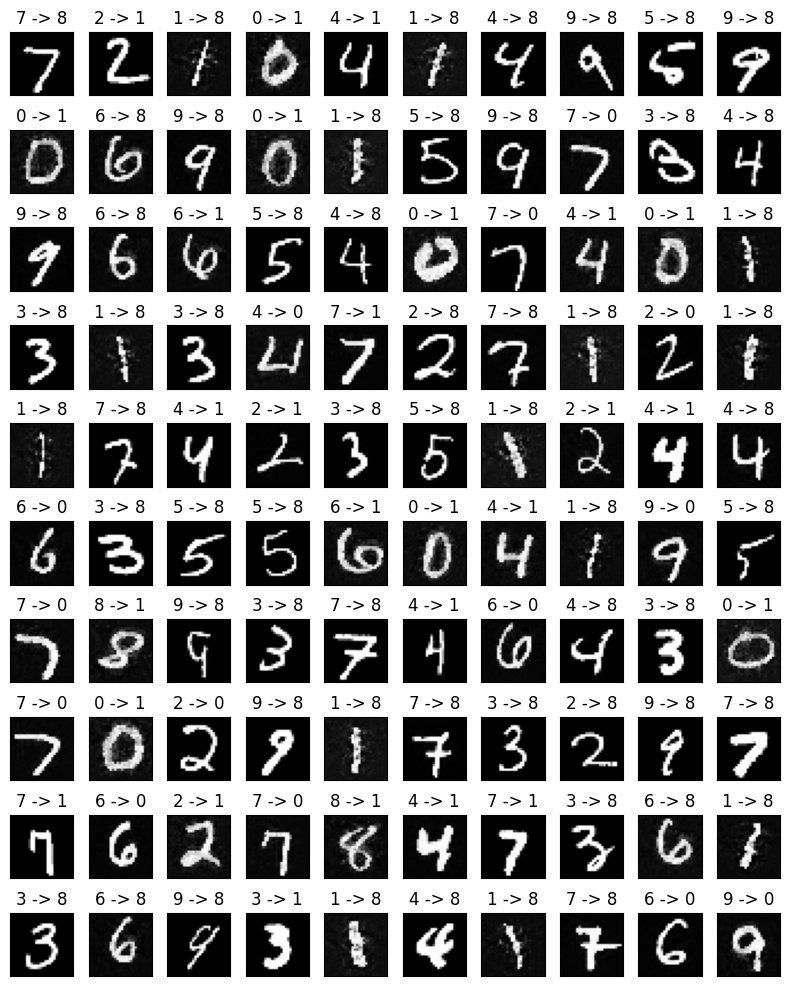

In [9]:
num_cols = len(adv_examples)
print(num_cols)

# fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))  # Adjust figsize as needed
# for i in range(num_cols):
#     true_label, false_label, image_data = adv_examples[i]
    
#     true_label = true_label.item()
#     false_label = false_label.item()
    
#     axes[i].imshow(image_data, cmap='gray')  # Assuming the image is grayscale, adjust cmap as needed
#     title = f"{true_label} -> {false_label}"
#     axes[i].set_title(title)
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])

# plt.tight_layout()
# plt.show()

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [10]:
adv_examples = test_cw(cifar_resnet_model, test_loader_cifar10, mnist = 0)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
1 / 24
1 / 25
1 / 26
1 / 27
1 / 28
1 / 29
1 / 30
1 / 31
1 / 32
1 / 33
1 / 34
1 / 35
1 / 36
1 / 37
1 / 38
1 / 39
1 / 40
1 / 41
1 / 42
1 / 43
1 / 44
1 / 45
1 / 46
1 / 47
1 / 48
1 / 49
1 / 50
1 / 51
1 / 52
1 / 53
1 / 54
1 / 55
2 / 56
2 / 57
2 / 58
3 / 59
3 / 60
3 / 61
3 / 62
3 / 63
3 / 64
3 / 65
3 / 66
3 / 67
3 / 68
3 / 69
3 / 70
3 / 71
3 / 72
3 / 73
3 / 74
3 / 75
3 / 76
3 / 77
3 / 78
3 / 79
3 / 80
3 / 81
3 / 82
3 / 83
3 / 84
3 / 85
3 / 86
3 / 87
3 / 88
3 / 89
3 / 90
3 / 91
3 / 92
3 / 93
3 / 94
3 / 95
3 / 96
3 / 97
3 / 98
3 / 99
3 / 100
3 / 101
3 / 102
3 / 103
3 / 104
Accuracy of test text: 2.884615 %


[[[0.298809   0.2995857  0.29890049 ... 0.29849875 0.29837644 0.29783165]
  [0.29831868 0.29752997 0.2974292  ... 0.2977194  0.3022314  0.30297333]
  [0.29855028 0.29649454 0.29716575 ... 0.30084497 0.29846585 0.2997792 ]
  ...
  [0.3099702  0.31601918 0.3161739  ... 0.3064014  0.3032397  0.3011836 ]
  [0.303362   0.3015958  0.30077574 ... 0.298899   0.30035582 0.29802048]
  [0.30473167 0.3038913  0.29936433 ... 0.29854262 0.29999924 0.29912403]]

 [[0.40480453 0.40203336 0.40723753 ... 0.3833508  0.39690003 0.37420744]
  [0.40238327 0.4034908  0.39515534 ... 0.39254445 0.388171   0.3837955 ]
  [0.4101287  0.39852005 0.41164988 ... 0.38266516 0.38361216 0.3830846 ]
  ...
  [0.48013648 0.48855656 0.47178572 ... 0.4821004  0.46031263 0.45485225]
  [0.47128373 0.4604616  0.45373777 ... 0.45303923 0.45974892 0.44767395]
  [0.46211413 0.45744553 0.44770563 ... 0.44090444 0.45052546 0.44765693]]

 [[0.30610663 0.307926   0.31097773 ... 0.30651802 0.3081197  0.3062693 ]
  [0.30716977 0.306862

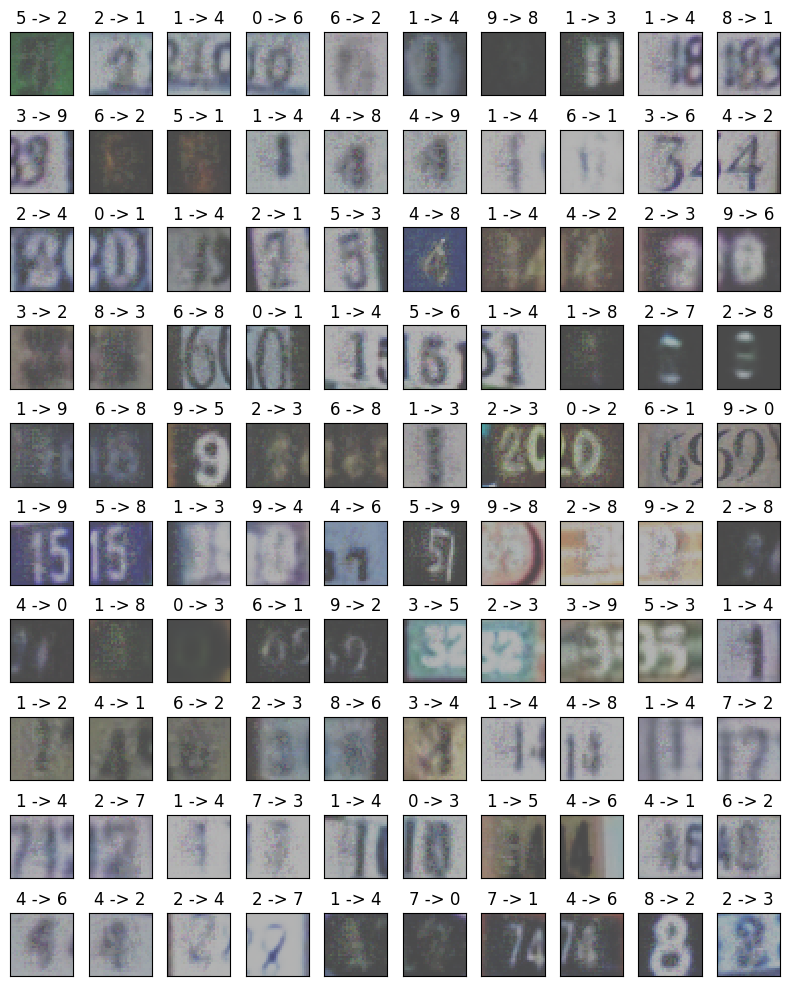

In [11]:
# Test visualizer with an image available in test data
viz = Visualizer()
label_mapping2 = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}



# for img in adv_examples:
#     print(label_mapping2[img[0].item()])
#     print(label_mapping2[img[1].item()])
#     image = img[2] 
#     viz.show(image)

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [12]:
adv_examples = test_cw(svhn_resnet_model, test_loader_svhn, mnist = 0)

0 / 1
0 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
2 / 10
2 / 11
2 / 12
3 / 13
3 / 14
3 / 15
3 / 16
3 / 17
3 / 18
3 / 19
3 / 20
3 / 21
3 / 22
4 / 23
4 / 24
4 / 25
4 / 26
4 / 27
4 / 28
4 / 29
4 / 30
4 / 31
4 / 32
4 / 33
4 / 34
4 / 35
4 / 36
5 / 37
5 / 38
5 / 39
5 / 40
5 / 41
5 / 42
5 / 43
5 / 44
5 / 45
5 / 46
5 / 47
5 / 48
5 / 49
5 / 50
5 / 51
5 / 52
5 / 53
5 / 54
5 / 55
5 / 56
5 / 57
5 / 58
5 / 59
5 / 60
5 / 61
6 / 62
6 / 63
6 / 64
6 / 65
6 / 66
6 / 67
6 / 68
7 / 69
7 / 70
7 / 71
7 / 72
7 / 73
7 / 74
7 / 75
7 / 76
7 / 77
7 / 78
7 / 79
7 / 80
7 / 81
7 / 82
7 / 83
7 / 84
7 / 85
7 / 86
7 / 87
7 / 88
7 / 89
7 / 90
7 / 91
7 / 92
7 / 93
7 / 94
7 / 95
7 / 96
7 / 97
7 / 98
7 / 99
7 / 100
7 / 101
7 / 102
7 / 103
8 / 104
8 / 105
8 / 106
8 / 107
8 / 108
8 / 109
Accuracy of test text: 7.339450 %


[[[0.63303113 0.5549759  0.605173   ... 0.5242679  0.4917803  0.4515792 ]
  [0.58617055 0.59266526 0.6174298  ... 0.52607363 0.49027365 0.4630349 ]
  [0.6165903  0.6157565  0.61054623 ... 0.5479754  0.52734315 0.48482043]
  ...
  [0.3169964  0.29760706 0.30169153 ... 0.30723077 0.29622346 0.30021703]
  [0.3057632  0.29996267 0.29922682 ... 0.29668838 0.29621524 0.29288536]
  [0.30171344 0.3036436  0.30284896 ... 0.29413322 0.296602   0.29635113]]

 [[0.43165836 0.41170156 0.426009   ... 0.37758598 0.37250265 0.33128694]
  [0.44553006 0.41773498 0.4659644  ... 0.36530465 0.36190218 0.3425529 ]
  [0.41427654 0.4346726  0.4287354  ... 0.41899404 0.3767587  0.35427332]
  ...
  [0.49697426 0.38900262 0.3427104  ... 0.38996553 0.31364363 0.347771  ]
  [0.4502887  0.3975352  0.33921808 ... 0.3483026  0.33680665 0.31493953]
  [0.41598123 0.41962716 0.36335093 ... 0.33281955 0.3406639  0.316403  ]]

 [[0.33708662 0.32677168 0.33113578 ... 0.2974323  0.30006495 0.2952202 ]
  [0.32425618 0.346619

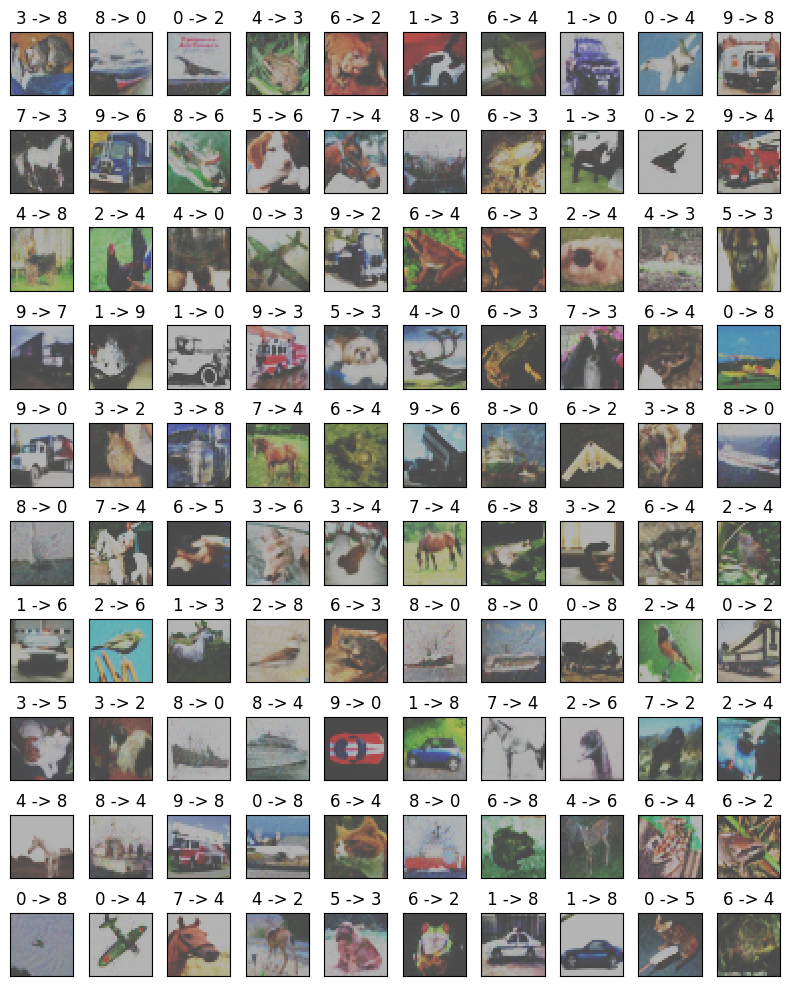

In [15]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
# for img in adv_examples:
#     print(label_mapping[img[0].item()])
#     print(label_mapping[img[1].item()])
#     image = img[2]
#     viz.show(image)

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()